## Libraries

In [121]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy import stats

import re
import nltk 
import tensorflow as tf
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

import warnings 
warnings.filterwarnings("ignore")

# Download necessary NLTK data
nltk.download("stopwords")
nltk.download("punkt")

import pickle


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Loading the Dataset

In [122]:
# Load the dataset
df = pd.read_csv('data/IMDB Dataset.csv')
df.head()


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [123]:
df.columns

Index(['review', 'sentiment'], dtype='object')

In [124]:
df.shape

(50000, 2)

In [125]:
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [126]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


## Data Exploration

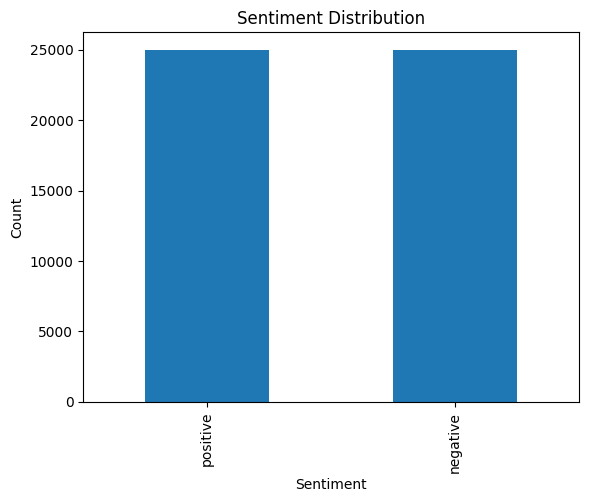

In [127]:
# Distribution of sentiment labels
df['sentiment'].value_counts().plot(kind='bar')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()


## Data Preprocessing

- Removing punctuation from the data.
- Eliminating unnecessary symbols in the dataset.
- Converting text to lowercase.
- Removing extra spaces.
- Filtering out stopwords from sentences.

In [128]:
# Cleaning the review
df['review'] = df['review'].apply(lambda x: re.sub('[,\.!?:()"]', '', x))
df['review'] = df['review'].apply(lambda x: re.sub('[^a-zA-Z"]', ' ', x))
df['review'] = df['review'].apply(lambda x: x.lower())
df['review'] = df['review'].apply(lambda x: x.strip())

In [129]:
stopwords = set(stopwords.words('english'))
print (f"number of words in our stopwords list: {len(stopwords)}")

number of words in our stopwords list: 179


In [130]:
sentiment = df['sentiment'].values
review = df['review']

In [131]:
# Map sentiment labels to binary
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})

In [132]:
df.head()

,review,sentiment
0,one of the other reviewers has mentioned that ...,1
1,a wonderful little production br br the ...,1
2,i thought this was a wonderful way to spend ti...,1
3,basically there s a family where a little boy ...,0
4,petter mattei s love in the time of money is a...,1


In [133]:
# Train and Test Split Data
x_train, x_test, y_train, y_test = train_test_split(review,sentiment,test_size = 0.2, random_state = 42)

# Tokenization
tokenizer = Tokenizer(num_words = 15000)
tokenizer.fit_on_texts(review)

# Convert tokens to sequences of integers
x_train_tokens = tokenizer.texts_to_sequences(x_train)
x_test_tokens = tokenizer.texts_to_sequences(x_test)

# Determine the number of tokens per review 
n_tokens = [len(tokens) for tokens in x_train_tokens + x_test_tokens]
n_tokens = np.array(n_tokens)

# Determine the maximum number of tokens 
tokens = np.mean(n_tokens) + 2 * np.std(n_tokens)
tokens = int(tokens)
tokens

567

In [134]:
np.sum(n_tokens < tokens) / len(n_tokens)

0.94524

In [135]:
#data is adjusted according to the number of tokens specified
x_train_pad_sequences = pad_sequences(x_train_tokens, maxlen=tokens)
x_test_pad_sequences = pad_sequences(x_test_tokens, maxlen=tokens)

x_train_pad_sequences.shape

(40000, 567)

In [136]:
idx = tokenizer.word_index
inverse_map = dict(zip(idx.values(), idx.keys()))

def return_to_sentence(tokens):
    words = [inverse_map[token] for token in tokens if token!=0]
    text = ' '.join(words)
    return text

In [137]:
print(return_to_sentence(x_train_pad_sequences[9]))

hated jews and just in case you miss this we re going to the fact in every scene in the film br br there was no effort whatsoever to try and explain the mood of the time and why hitler may have adopted the views and strategy he did needless to say unlike the generally excellent nazis a warning from history this film neglected to point out the fact that nearly all of the leaders of the munich communist rising were jewish and that this may have his views on the subject and his linking of the jews with an absolutely crucial aspect to understanding much of the nazi era br br but there was not much understanding to be done the film makers weren t going to go there so we just got all the stuff we knew about anyway we certainly don t get the fascinating fact that to which has hitler briefly being a socialist communist immediately after ww that would of course be far too complex for the film to handle and might even detract from the relentless he was very bad which away incessantly br br we kn

In [ ]:
# Map string labels to numeric values
y_train = np.array(y_train)
label_mapping = {'negative': 0, 'positive': 1}
y_train_numeric = np.array([label_mapping[label] for label in y_train])

# Convert to float
y_train_numeric = y_train_numeric.astype('float32')

# Ensure features data is in the correct format
x_train_pad = np.array(x_train_pad_sequences)
if x_train_pad.dtype != 'int32':
    x_train_pad = x_train_pad.astype('int32')

# Print data types for verification
print(f"x_train_pad dtype: {x_train_pad.dtype}")
print(f"y_train_numeric dtype: {y_train_numeric.dtype}")
print(f"Unique values in y_train_numeric: {np.unique(y_train_numeric)}")

## Building the RNN Model

In [158]:
# Create the model
model = Sequential()
model.add(Embedding(input_dim=15000, output_dim=128, input_length=tokens))
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(64))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
optimizer = Adam(learning_rate=1e-3)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Build the model
model.build((None, tokens))

# Print model summary
model.summary()

Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_12 (Embedding)        │ (None, 567, 128)       │     1,920,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_65 (LSTM)                  │ (None, 567, 128)       │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_66 (LSTM)                  │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,101,057 (8.01 MB)

 Trainable params: 2,101,057 (8.01 MB)

 Non-trainable params: 0 (0.00 B)

## Training the Model

In [159]:
# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Proceed with training
training = model.fit(x_train_pad, y_train_numeric, validation_split=0.3, epochs=5, batch_size=1000, shuffle=True, verbose=1 ,callbacks=[early_stopping])

Epoch 1/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 384s 14s/step - accuracy: 0.5716 - loss: 0.6729 - val_accuracy: 0.7206 - val_loss: 0.5998
Epoch 2/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 368s 13s/step - accuracy: 0.7678 - loss: 0.5184 - val_accuracy: 0.8195 - val_loss: 0.4077
Epoch 3/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 356s 13s/step - accuracy: 0.8630 - loss: 0.3400 - val_accuracy: 0.8534 - val_loss: 0.3464
Epoch 4/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 355s 13s/step - accuracy: 0.9023 - loss: 0.2582 - val_accuracy: 0.8707 - val_loss: 0.3201
Epoch 5/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 354s 13s/step - accuracy: 0.9360 - loss: 0.1838 - val_accuracy: 0.8752 - val_loss: 0.3333


- The model shows a significant improvement in both training and validation accuracy over the epochs.
- The accuracy increased from 57.16% in the first epoch to 93.60% by the fifth epoch.
- Validation accuracy also improved from 72.06% to 87.52%, indicating the model is generalizing well.
- Training loss decreased from 0.6729 to 0.1838, and validation loss decreased from 0.5998 to 0.3333.
- The decreasing loss values indicate that the model is learning effectively and fitting the data better with each epoch.

## Evaluating the Model

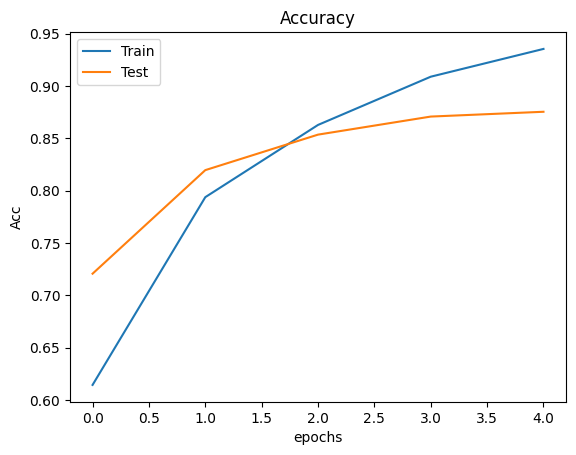

In [160]:
# Plotting the training accuracy
plt.figure()
plt.plot(training.history["accuracy"], label = "Train")
plt.plot(training.history["val_accuracy"], label = "Test")
plt.title("Accuracy")
plt.ylabel("Acc")
plt.xlabel("epochs")
plt.legend()
plt.show()

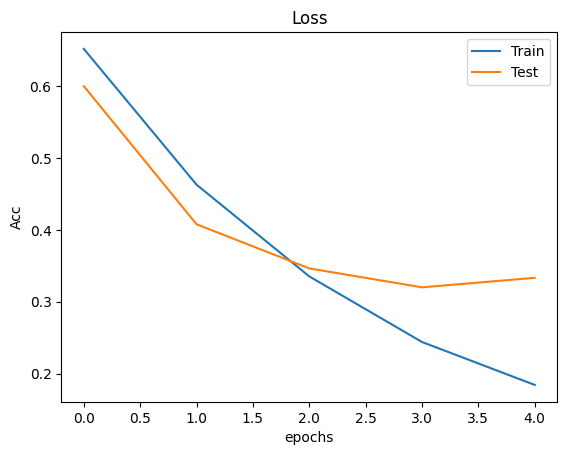

In [161]:
# Plotting the results loss
plt.figure()
plt.plot(training.history["loss"], label = "Train")
plt.plot(training.history["val_loss"], label = "Test")
plt.title("Loss")
plt.ylabel("Acc")
plt.xlabel("epochs")
plt.legend()
plt.show()

## Hyperparameter Tuning

In [162]:
# Example of changing hyperparameters
modified_model = Sequential()
modified_model.add(Embedding(input_dim=15000, output_dim=128, input_length=tokens))

# Changed number of units
modified_model.add(LSTM(128, return_sequences=True))  

 # Added dropout for regularization
modified_model.add(Dropout(0.5)) 
modified_model.add(LSTM(64))
modified_model.add(Dense(1, activation='sigmoid'))

# Compile and train with new hyperparameters
modified_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Build the model
modified_model.build((None, tokens))

# Print model summary
modified_model.summary()

Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_13 (Embedding)        │ (None, 567, 128)       │     1,920,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_67 (LSTM)                  │ (None, 567, 128)       │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_58 (Dropout)            │ (None, 567, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_68 (LSTM)                  │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,101,057 (8.01 MB)

 Trainable params: 2,101,057 (8.01 MB)

 Non-trainable params: 0 (0.00 B)

In [163]:
# Proceed with training
modified_training = modified_model.fit(x_train_pad, y_train_numeric, validation_split=0.3, epochs=5, batch_size=1000, shuffle=True, verbose=1 ,callbacks=[early_stopping])

Epoch 1/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 374s 13s/step - accuracy: 0.6075 - loss: 0.6402 - val_accuracy: 0.8205 - val_loss: 0.3967
Epoch 2/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 396s 14s/step - accuracy: 0.8219 - loss: 0.4168 - val_accuracy: 0.8328 - val_loss: 0.3924
Epoch 3/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 429s 15s/step - accuracy: 0.8775 - loss: 0.3062 - val_accuracy: 0.8583 - val_loss: 0.3361


## Comparative Analysis

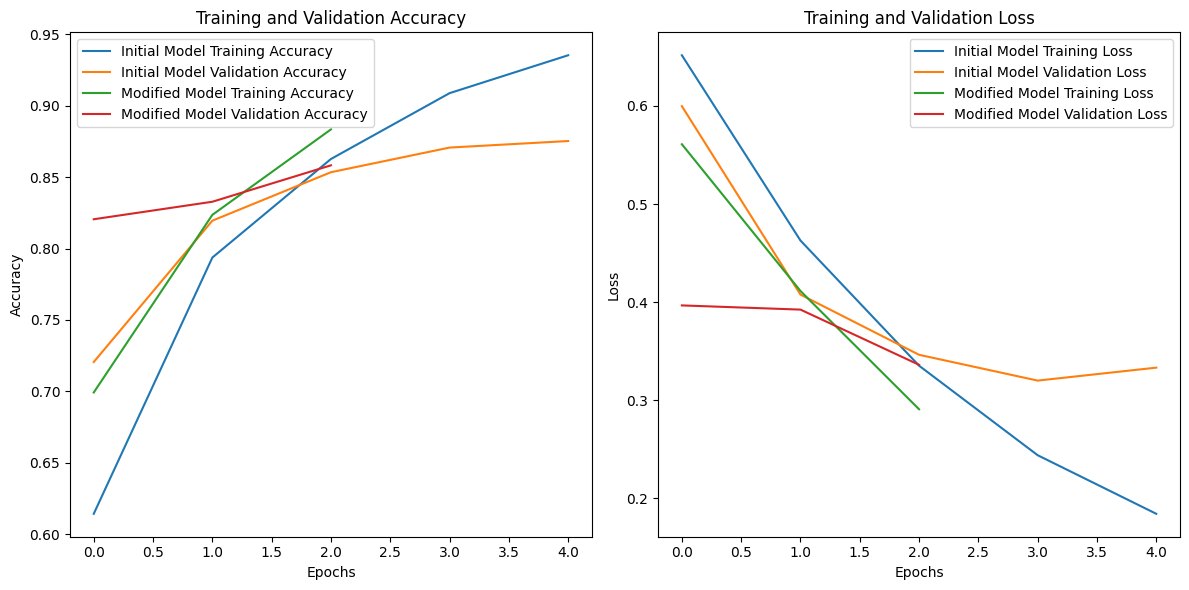

In [164]:
# Accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(training.history['accuracy'], label='Initial Model Training Accuracy')
plt.plot(training.history['val_accuracy'], label='Initial Model Validation Accuracy')
plt.plot(modified_training.history['accuracy'], label='Modified Model Training Accuracy')
plt.plot(modified_training.history['val_accuracy'], label='Modified Model Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(training.history['loss'], label='Initial Model Training Loss')
plt.plot(training.history['val_loss'], label='Initial Model Validation Loss')
plt.plot(modified_training.history['loss'], label='Modified Model Training Loss')
plt.plot(modified_training.history['val_loss'], label='Modified Model Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

- The modified model seems to generalize better, with closer alignment between training and validation metrics.
- The initial model shows signs of overfitting, with increasing gap between training and validation performance.
- By the final epoch, the modified model achieves higher validation accuracy and lower validation loss compared to the initial model.

## Saving the Model and Scaler

In [166]:
# Save the model
modified_model.save('best_model.h5')

# Save the tokenizer
import pickle
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)
